### 이진화
- 이진 영상
  - 검은색(0)과 흰색(255)만으로 표현한 영상
- 이진화
  - 그레이스케일(grayscale) 영상을 이진(binary) 영상으로 만드는 과정
  - 특정한 밝기값(역치값, threshold value)을 기준으로 그보다 어두운 화소는 검은색, 밝은 화소는 흰색으로 변환
  - 스레시홀딩(thresholding)이라고도 함.
- 전역 이진화(global thresholding)
  - 전체 이미지를 하나의 역치값으로 변환
  - 히스토그램 이용
  - 오츠 알고리즘
- 적응형 이진화(adaptive thresholding)
  - 배경이 일정하지 않거나 배경색이 여러 가지인 경우
  - 영상의 영역에 따라 다른 역치값을 적용해 이진화함


- ex) 광학 문자 인식(ocr)

- ret, out = cv2.threshold(img, threshold, value, type__flag)
  - img: Numpy 배열, 변환할 이미지
  - threshold: 경계값
  - value: 경계값 기준에 만족하는 픽셀에 적용할 값
  - type_flag: 경계값 적용방법 지정
    - cv2.THRESH_BINARY: px > threshold ? value : 0
    - cv2.THRESH_BINARY_INV: px > threshold ? 0 : value
    - cv2.THRESH_TRUNC: px > threshold ? value : px
    - cv2.THRESH_TOZERO: px > threshold ? px : 0
    - cv2.THRESH_TOZERO_INV: px > threshold ? 0 : px
  - ret: 사용한 경계값
  - out: 결과 바이너리 이미지

https://bkshin.tistory.com/entry/OpenCV-8-%EC%8A%A4%EB%A0%88%EC%8B%9C%ED%99%80%EB%94%A9Thresholding

In [1]:
# gray_gradient 이미지 만들기
import numpy as np, cv2
img=np.zeros((100,256), dtype=np.uint8)
for i in range(100):
    for j in range(256):
        img[i, j] = j
cv2.imshow('img', img)
cv2.imwrite('images/gray_gradient256.jpg', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

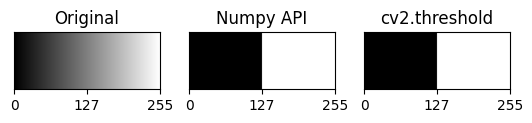

In [2]:
import numpy as np, cv2
import matplotlib.pyplot as plt

img = cv2.imread('images/gray_gradient256.jpg', cv2.IMREAD_GRAYSCALE)

thresh_np = np.zeros_like(img)
thresh_np[img>127] = 255

ret, thresh_cv = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

imgs={'Original':img, 'Numpy API': thresh_np, 'cv2.threshold': thresh_cv}

for i, (key, value) in enumerate(imgs.items()):
    plt.subplot(1,3,i+1)
    plt.title(key)
    plt.imshow(value, cmap='gray')
    plt.xticks((0, 127, 255)); plt.yticks([])

plt.show()

### 컬러 영상의 이진화

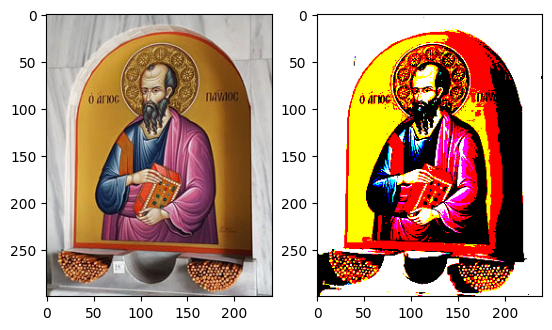

In [3]:
img = cv2.imread('images/matplot.jpg', cv2.IMREAD_COLOR)
ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(thresh[:,:,::-1])
plt.show()

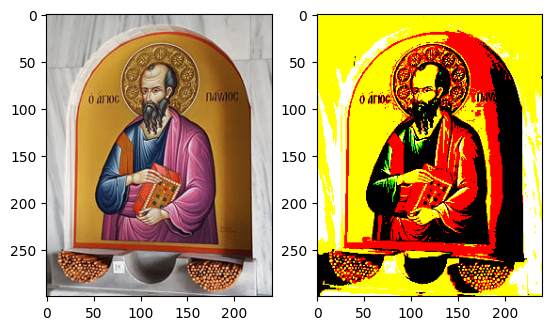

In [4]:
img = cv2.imread('images/matplot.jpg', cv2.IMREAD_COLOR)
b,g,r = cv2.split(img)
_, th_b = cv2.threshold(b, 200, 255, cv2.THRESH_BINARY)
_, th_g = cv2.threshold(g, 127, 255, cv2.THRESH_BINARY)
_, th_r = cv2.threshold(r, 127, 255, cv2.THRESH_BINARY)

img_thresh = cv2.merge((th_b, th_g, th_r))

plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(img_thresh[:,:,::-1])
plt.show()

### 오츠(Otus) 알고리즘
- 이진화는 이미지를 두 개의 클래스로 나누는 분류(classification) 알고리즘으로 생각할 수 있음
- 클래스를 나누는데 드는 비용함수로 생각해 비용이 가장 적게 드는 상태가 가장 좋은 경우임
  - 경계값과 픽셀값의 차를 비용으로 간주

- 비용 함수
  - intra-class variance: 최소값 $\to$ $\sigma^2_w(t) = w_1(t) \sigma^2_1(t) + w_2(t) \sigma ^2_2$
  - inter-class variance: 최대값 $\to$ $\sigma^2_w(t) = w_1(t)w_2(t)(\mu_1 - \mu_2)^2$
    - t: 0~255(경계값)
    - $w_1, w_2$: 각 영역의 비율 가중치(전체 픽셀 수에서 각 영역에 속하는 픽셀 수의 비율)
    - $\sigma^2_1, \sigma^2_2$: 각 영역의 분산
    - $\mu_1, \mu_2$: 각 영역의 평균
- 두 분산에 대한 참조: https://www.statisticalaid.com/intra-class-vs-inter-classcorrelation/
- 다양한 값의 분포를 가진 영역에서 분산값이 가장 작은 값을 대표값으로 하기 좋음
- 한 값(threshold)으로 나눈 두 영역에서 각각의 분산값이 가장 작게 나오는 값을 찾는 알고리즘

- intra-class variance: 분산값을 계산하기 때문에 오래걸림
- inter-class variance: 전체 분산값$(\sigma^2(t))$는 threshold 값을 바꿔가면서 진행되는 알고리즘에서 상수값에 해당함, 각 클래스의 분산값은 식을 전개하면서 평균값의 연산$((\mu_1(t) - \mu_2(t))^2)$으로 대체되기 때문에 계산량이 적음
  - 실제로 구현할 때는 threshold 값을 0~255까지 차례로 적용하면서 이 평균값들도 점화식 형태로 계한해 계산 속도를 빠르게 함
- 인트라 클래스는 분산을 계산해야 하기에 계산량이 많고 느림<br>
  인터 클래스는 평균값 차이로 대체가 가능해 계산이 빠름

- 전체적으로 어두운 이미지 -> 낮은 값으로 나눠야 적절하게 나눔<br>
  전체적으로 밝은 이미지 -> 높은 값으로 나눠야 적절하게 나눔
- 분산 값이 커야 좋음
  - 분산이 크다 -> 두 클래스의 평균이 멀리 떨어져 있다 -> 배경과 객체의 밝기가 잘 구분 됨
  - 클수록 좋은 이유: 서로 구별되는 정도가 크기 때문에 경계가 뚜렷하고 오류가 적음

otsu threshold: 127.0


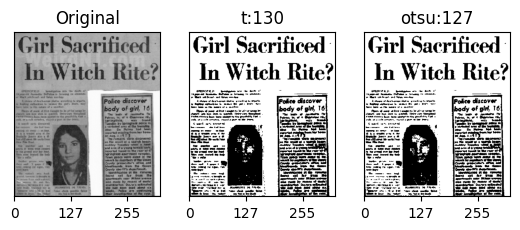

In [5]:
img = cv2.imread('images/scaned_paper.jpg', cv2.IMREAD_GRAYSCALE)

_, t_130 = cv2.threshold(img, 130, 255, cv2.THRESH_BINARY)

t, t_otsu = cv2.threshold(img, -1, 255,  cv2.THRESH_BINARY | cv2.THRESH_OTSU) 
print('otsu threshold:', t)

imgs = {'Original': img, 't:130':t_130, 'otsu:%d'%t: t_otsu}

for i, (key, value) in enumerate(imgs.items()):
    plt.subplot(1,3,i+1)
    plt.title(key)
    plt.imshow(value, cmap='gray')
    plt.xticks((0, 127, 255)); plt.yticks([])

plt.show()

### 적응형 이진화
- 블록 사이즈가 작으면 세세하게 보기 좋지만 너무 작으면 의미가 없는 값이 돼버릴 수 있음

- cv2.adaptiveThreshold(img, value, method, type_flag, block_size, C)
  - img: 입력 영상
  - value: 경계값을 만족하는 픽셀에 적용할 값
  - method: 경계값을 만족하는 픽셀에 적용할 값
    - cv2.ADAPTIVE_THRESH_MEAN_C: 이웃 픽셀의 평균으로 결정
    - cv2.ADAPTIVE_THRESH_GAUSSIAN_C: 가우시안 분포에 따른 가중치의 합으로 결정
  - type_flag: 경계값 적용방법 지정(cv2.threshold() 함수와 동일)
  - block_size: 영역으로 나눌 이웃의 크기(n x n), 홀수(3,5,7,...)
  - C: 계산된 경계값 결과에서 가감할 상수(음수 가능)

### 동영상에서 절대값 차를 이용해서 움직임을 감지하려면?

- y가 u와 v의 정보량이 2배라 YUV를 사용하는 것이 더 유리

- frame_v = cv2.split(frame_hsv)[0] -> YUV

In [6]:
# HUV
import numpy as np, cv2
import matplotlib.pyplot as plt

capture = cv2.VideoCapture(0)
_, pre = capture.read()
pre_hsv = cv2.cvtColor(pre, cv2.COLOR_BGR2HSV)
pre_v = cv2.split(pre_hsv)[2]
while True:
   ret, frame = capture.read()
   if not ret: break
   if cv2.waitKey(30) >= 0: break
   frame = cv2.flip(frame, 1)   # 좌우반전
   frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
   frame_v = cv2.split(frame_hsv)[2]   # 밝기(value)값
   diff = cv2.absdiff(pre_v, frame_v)   # 차분 추출
   diff[diff<30] = 0
   cv2.imshow('absdiff', diff)
   pre_v = frame_v
capture.release()
cv2.destroyAllWindows()

In [7]:
# YUV
import numpy as np, cv2
import matplotlib.pyplot as plt
capture = cv2.VideoCapture(0)
_, pre = capture.read()
pre_yuv = cv2.cvtColor(pre, cv2.COLOR_BGR2YUV)
pre_y = cv2.split(pre_yuv)[0]
while True:
   ret, frame = capture.read()
   if not ret: break
   if cv2.waitKey(30) >= 0: break
   frame = cv2.flip(frame, 1)   # 좌우반전
   frame_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
   frame_y = cv2.split(frame_yuv)[0]
   diff = cv2.absdiff(pre_y, frame_y)
#  diff[diff<30] = 0
   cv2.imshow('absdiff', diff)
   pre_y = frame_y
capture.release()
cv2.destroyAllWindows()

### ROI 함수


In [8]:
# 5-7 행렬 비트 연산
import numpy as np, cv2

image1 = np.zeros((300, 300), np.uint8)
image2 = image1.copy()

h,w = image1.shape[:2]
cx, cy = w//2, h//2
cv2.circle(image1, (cx, cy), 100, 255, -1)
cv2.rectangle(image2, (0, 0, cx, h), 255, -1)

image3 = cv2.bitwise_or(image1, image2)
image4 = cv2.bitwise_and(image1, image2)
image5 = cv2.bitwise_xor(image1, image2)
image6 = cv2.bitwise_not(image1)

cv2.imshow('image1', image1)
cv2.imshow('image2', image2)
cv2.imshow('bitwise_or', image3)
cv2.imshow('bitwise_and', image4)
cv2.imshow('bitwise_xor', image5)
cv2.imshow('bitwise_not', image6)

cv2.waitKey(0)
cv2.destroyAllWindows()

### 관심영역
ret = cv2.selectROI([win_name,], img[, showCrossHair=True, fromCenter=Fasle])

- win_name: ROI 선택을 진행할 창의 이름, str
- img: ROI 선택을 진행할 이미지, Numpy ndarray
- showCrossHair: 선택 영역 중심에 십자 모양 표시 여부
- fromCenter: 마우스 시작 지점을 영역의 중심으로 지정
- ret: 선택한 영역 좌표와 크기(x, y, w, h), 선택을 취소한 경우 모두 0

- 영역 선택 후 spacebar나 enterkey를 누르면 좌표와 크기값이 반환됨
- c 키를 누르면 선택이 취소되고 리턴값은 모두 0이 됨

In [11]:
import numpy as np, cv2

image=cv2.imread("images/bit_test.jpg", cv2.IMREAD_COLOR)
logo=cv2.imread("images/logo.jpg", cv2.IMREAD_COLOR)
if image is None or logo is None: raise Exception("영상파일 읽기 오류")

masks = cv2.threshold(logo, 220, 255, cv2.THRESH_BINARY)[1]
masks = cv2.split(masks)

fg_pass_mask = cv2.bitwise_or(masks[0], masks[1])
fg_pass_mask = cv2.bitwise_or(masks[2], fg_pass_mask)
bg_pass_mask = cv2.bitwise_not(fg_pass_mask)

(H,W), (h,w) = image.shape[:2], logo.shape[:2]
x, y = (W-w)//2, (H-h)//2
roi = image[y:y+h, x:x+w]

foreground = cv2.bitwise_and(logo,logo,mask=fg_pass_mask)
background = cv2.bitwise_and(roi,roi,mask=bg_pass_mask)

dst = cv2.add(background, foreground)
image[y:y+h, x:x+w] = dst

cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()